# Bayesian inference as learning

In the last lecture, we introduced Bayes theorem. We applied it to the globe tossing problem as a technique for estimating the surface area of the earth that's covered in water. In this lecture, I want to do two things. First, I want to linger over the globe tossing problem for a while. We want to improve the algorithm a bit and explore some of it's properties. What happens if we test 100 hundreds hypotheses instead of 10? What happens if we increase the sample? What happens if we adjust the prior distribution?

Second, once we feel comfortable with the mechanics of Bayesian inference, I want to reflect on some of the philosophical issues here. What's better? Popperian hypothesis testing or Bayesian estimation? There are are trade offs involved in each. These trade offs arise because of fundamental limitations on inductive inferences. So mediating on them can help us appreciate what science can and cannot do for us.

# A quick review

Last time we got introduced to Bayes theorem:

$$ P(H|E) = P(H) \frac{P(E|H)}{P(E)} $$

It's elegant but we quickly learned that we usually need to replace the denominator with the law of total probability. Expressed in this form, it looks like this:

$$ P(H|E) = P(H) \frac{P(E|H)}{\sum_{i=1}^{n} P(E|H_i)P(H_i)} $$

This is the form of the theorem that we'll rely on. Bayes theorem is so important that every term gets a special name:

$ P(H|E) $ - The posterior, or what we are trying to estimate.

$ P(H) $ - The prior, or our prior confidence in a given hypothesis.

$ P(E|H) $ - The likelihood, or a p-value. This is what we were calculating last week. We can use the binomial distribution or the normal distribution to calculate it. There are dozens of other common likelihood functions too.

$ \sum_{i=1}^{n} P(E|H_i)P(H_i) $ - The expectation. A weighted average of the probability of finding data like this across all the hypotheses.

## The globe tossing problem

Let's remember the structure of our problem:

We were trying to estimate what percentage of the earth's surface is covered in water. We took a globe and tossed it up in the air and recorded the results. The results were: water, land, water, water, water, land, water, land, water. Or, simply, 6 waters and 9 tosses.

To get an estimate we need three ingredients.

- A set of hypotheses to try. We noticed that Bayes theorem only works when we have more than one hypothesis under consideration. In the code below, we tried a set of 10 hypotheses from 0.1-1.
- A prior distribution over that set of hypotheses. We need to know how much credibility each hypothesis should get before we look at the evidence. In the code below, that prior distribution was flat, every hypothesis has the same initial credibility.
- A likelihood function. We need to know how much like the data is under each hypotheses. For that we use the binomial simulation code we wrote last week.

Then we work though each hypothesis. We plug in the respective hypothesis to compute a likelihood and then multiply it by it's respective prior. When we are done, we divide each pair of prior & likelihood by the sum all pairs of priors and likelihoods. We ended on this sacred little bit of code.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def simulate_bristol(a,n):
    '''Returns a list of 0s and 1s of lengeth n
    with 0 indicating failure and 1 indicating success.
    
    a = accuracy on each cup
    n = the number of cups'''

    experiment = []

    for i in range(n):
        
        outcome = np.random.choice([1,0],p=[a,1-a])
        experiment.append(outcome)
        
    return experiment

def run_experiments(a,n,precision):
    '''Returns a list containing the number of cups lady bristol
    guessed correctly over many experiments
    
    a = accuracy on each cup
    n = number of cups per experiment
    precision = the number of experiments'''
    
    
    all_trials = []

    for i in range(precision):

        correct = sum(simulate_bristol(a,n))
        all_trials.append(correct)

    return all_trials

def likelihood_tea(a,n,k,precision):
    '''
    Compute the likelihood of getting k successes out of n
    trials assuming probability of success a on each trial.


    a = accuracy
    n = total number of trials
    k = the number of successes
    precision = the number of simulated experiments used to estimate
    the likelihood'''

    all_trials = run_experiments(a,n,precision)
    matches = all_trials.count(k)
    prob = matches / precision

    return prob

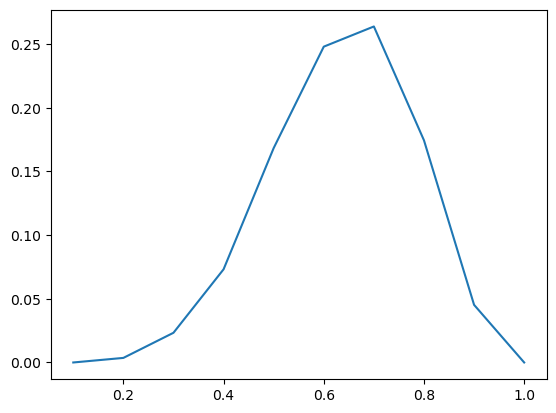

In [2]:
hypotheses = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1] # a list containing each of our hypotheses.

# let's find the likelihood of the data by momentarily
# assuming each hypothesis is true and then working
# through our binomial simulation code.

n = 9
k = 6
precision = 10000

likelihoods = [likelihood_tea(h,n,k,precision) for h in hypotheses]

# now we just need priors. Again, we'll assume each hypothesis has the same initial credibility.
# we need a list containing 10 probabilities that sum to 1.

priors = [1/10] * 10

# now we need to multipy each likelihood by it's respective prior.

posteriors = []
for i in range(10):
    posterior = priors[i] * likelihoods[i]
    posteriors.append(posterior)
    
# these posteriors haven't been divided by the expectation yet. Let's do that.
# it turns out we can just sum the list of the posteriors to get the average likelihood i.e the expectation.

expectation = sum(posteriors)

posteriors = [i / expectation for i in posteriors]

plt.plot(hypotheses,posteriors)

# Making Bayes Fast

We need a more computationally efficient way to implement the algorithm we just wrote. We ran through 10 hypotheses. Each hypotheses would use 10,000 trials to estimate the likelihood. Each trial would consistent of simulated tosses of the globe. Together, that's about 9 million computations, give or take. When we turn to more complex problems, all that time spent simulating will be quite the problem. Imagine just moving from 9 globe tosses to 1000 globe tosses. That would be 1 billion computations. So long as we remember what is going on under the hood, a better approach will use less simulation and more math.

## Arrays 

One trick we'll start utilizing from this class going forward are `arrays`. Downey discussed arrays a couple of weeks ago. They are like `lists` but have a couple of difference properties. Recall that addition and multiplication on lists was sorta weird:

In [4]:
[0,1,2,3] + [4,5,6,7]

[0, 1, 2, 3, 4, 5, 6, 7]

In [5]:
[0,1,2,3] * 2

[0, 1, 2, 3, 0, 1, 2, 3]

But if we do the same operation on arrays, they behave totally differently.

In [6]:
np.array([0,1,2,3]) + np.array([4,5,6,7])

array([ 4,  6,  8, 10])

In this case, it adds the item two items, the second two items and so on each list. It is *element-wise* addition.

In [8]:
np.array([0,1,2,3]) * 2

array([0, 2, 4, 6])

In this case, it multiples each entry of the array by 2.

Finally, this operation has no analogue with lists. But it performs element-wise multiplication.

In [9]:
np.array([0,1,2,3]) * np.array([4,5,6,7])

array([ 0,  5, 12, 21])

Arrays allow us to replace complex and long `for` loops with simple and fast expressions. Let's take each of the ingredients and write some better code for them, using arrays.

## The grid

We'll use the term **grid** to talk about the set of hypotheses we are going to try. `np.linspace()` is convenient for this purpose. Remember it generates an array of evenly spaced points between a start and stop interval.

In [14]:
import numpy as np

p_grid = np.linspace(.1,1,10) 
p_grid

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

The `np.linspace(.1,1,10)` function says: give me 10 points between 0.1 and 1. This way we can quickly compose grids of hypotheses. How would you get 50 points between 0.1 and 1?

In [ ]:
## rewrite here

## The prior

We're going to spend all of next class building various kinds of prior distributions. For now, we're just going to be building what are called *flat* priors - they assign the same initial probability to every point on the grid. So we need a simple piece of code that can make an arbitrary number of points and the sum of the all points is 1. One of the rules of probability is that that the sum of any given distribution is always one.

Step one is to make an arbitrary number of points that all have equal value. `np.ones` can make an array with as many ones in it as you please.

In [12]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Step two is to shrink of all them so the sum of the distribution adds up to one. There is a nice trick called normalization where you divide every entry in a list or array by the sum of that list or array. Then each entry just represents the proportion it is of the total.

In [11]:
prior_distribution = np.ones(10) / sum(np.ones(10))
prior_distribution

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

## The likelihood

As we mentioned, using the simulation function can be quite slow. So this is where learning stuff like `stats.binom().pmf` comes in handy. 

In [16]:
from scipy import stats

likelihoods = stats.binom(n=9, p=p_grid).pmf(k=6)
likelihoods

array([6.12360000e-05, 2.75251200e-03, 2.10039480e-02, 7.43178240e-02,
       1.64062500e-01, 2.50822656e-01, 2.66827932e-01, 1.76160768e-01,
       4.46410440e-02, 0.00000000e+00])

Notice that it returned 10 likelihoods instead of just one like it normally does. In the past, we've been looping through the various parameters we wanna try (usually k). But here, the stats function infers that we want to do something-like looping. When we pass it an array of parameters, it runs the calculation over each one and returns an array of likelihoods

## Putting the prior, grid, and likelihood together.

Picking out the prior, grid and likelihood require some decision making. The rest is just computation. 

In [9]:
posterior = likelihoods * prior_distribution

# and divide the array by the expectation

posterior = posterior / sum(posterior)
posterior

array([6.11961968e-05, 2.75072287e-03, 2.09902955e-02, 7.42695176e-02,
       1.63955860e-01, 2.50659622e-01, 2.66654495e-01, 1.76046264e-01,
       4.46120274e-02, 0.00000000e+00])

Now we'll put it all together. We've built a thing of real beauty. Admire it. Appreciate it. Remember to save this cell and never lose track of it.

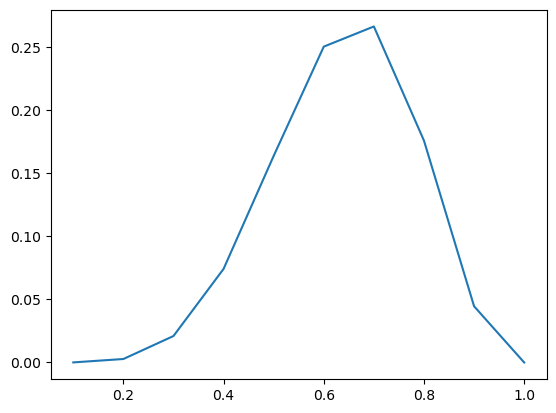

In [17]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

p_grid = np.linspace(.1,1,10) 
prior_distribution = np.ones(10) / sum(np.ones(10))
likelihoods = stats.binom(n=9,p=p_grid).pmf(k=6)
posterior = likelihoods * prior_distribution
posterior = posterior / sum(posterior)
plt.plot(p_grid,posterior)

# Watching Bayes theorem learn

For this next part, just sit back, relax and look at the graphs. I'm not going to explain my code as I go. I just want to give you a kind of metaphor for understanding how Bayes theorem works. 

Bayes theorem is naturally interpreted as a kind of learning process. Let's imagine we are receiving information about the globe. Except instead of looking at all 9 tosses, it comes in the form of one toss at a time. We're going to compute the posterior distribution after every toss to see just how the engine is improving in accuracy over time. Before we have any tosses at all, we have the prior distribution. This represents how good we think every hypothesis is before we receive empirical information.

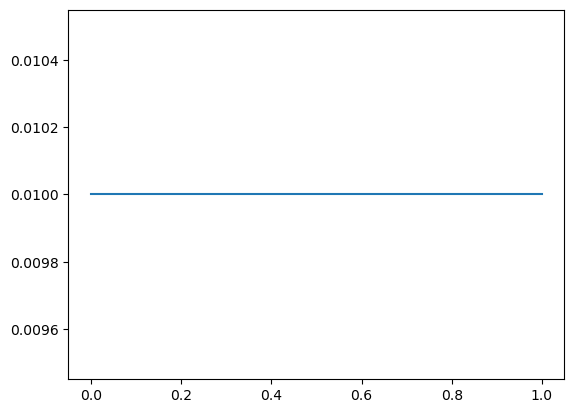

In [11]:
# plotting the prior distribution

grain = 100
p_grid = np.linspace(0,1,grain) 
prior_distribution = [1/grain] * grain

plt.plot(p_grid,prior_distribution)
plt.show()

Now we toss the globe and record that we found water. This flat distribution will shift in response to the new information. Those hypotheses that say there should be a high probability of finding water should grow in credibility at the expense of the those who predict a low probability of finding water.

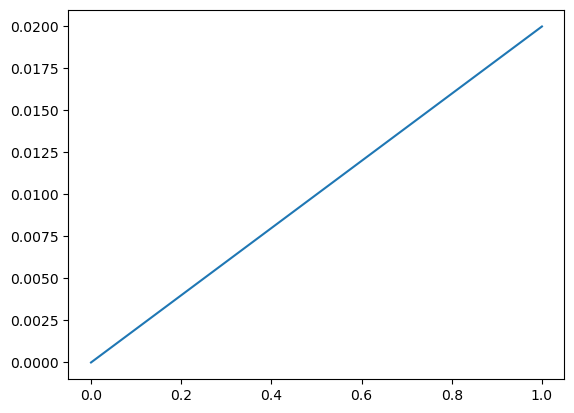

In [12]:
# the posterior distribution after 1 toss

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

grain = 100

p_grid = np.linspace(0,1,grain)
prior_distribution = [1/grain] * grain
likelihoods = stats.binom.pmf(1, 1, p=p_grid)
posterior = likelihoods * prior_distribution 
posterior = posterior / sum(posterior)
plt.plot(p_grid,posterior)
plt.show()

The plot is a line at 45 degrees. Let's make sure we really understand why it has this shape. Hypotheses that always predict water (100%, 99%, etc) do the best job of predicting a single water because they assign a probability at or close to 1 to the data. Hence that half of the line shifts upward. Hypotheses that say 50% of the surface area is water are will assign a 50% chance to getting water on the first toss. So their predictive capacity is exactly average and they stay right where they are. Finally, hypotheses that assign a low amount of water will shrink.

Things get more interesting with two tosses. The second toss finds land. So, in keeping with our pattern, that should shift some of the probability for the right hand side of the graph to the middle. Hypotheses that think 50% of the earth is covered in water now do best.

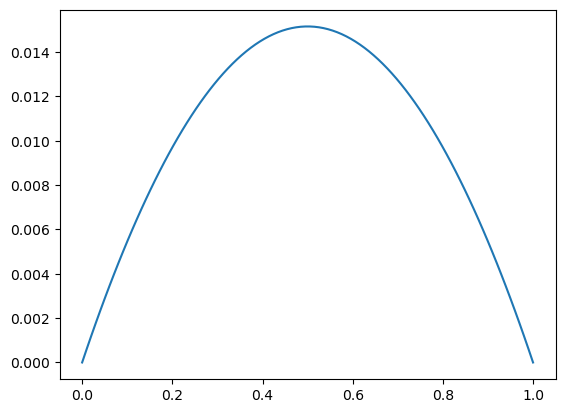

In [13]:
# after two tosses
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

grain = 100

p_grid = np.linspace(0,1,grain)
prior_distribution = [1/grain] * grain
likelihoods = stats.binom.pmf(1, 2, p=p_grid)
posterior = likelihoods * prior_distribution 
posterior = posterior / sum(posterior)
plt.plot(p_grid,posterior)
plt.show()

At this point, we can generalize the process. Here's 9 plots, where we computed the posterior distribution after each toss. You can see the posterior distribution slowly taking a more defined and stable shape as more information comes in. 

I've added a vertical line in orange depicting the real percentage of the earth's surface covered in water. You can see that the posterior distribution is beginning to center around the right answer. But also notice that goes through periods where it's converging in the wrong direction - that happens with small samples. As we toss the globe, we might get an anomalous string of 'land' results.

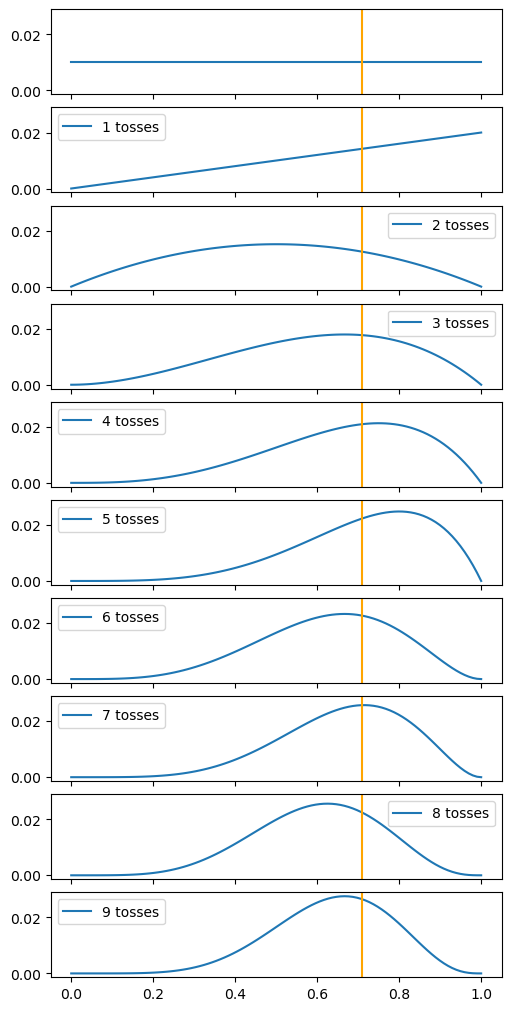

In [14]:
# All together now

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

k = [1,1,2,3,4,4,5,5,6]
n = [1,2,3,4,5,6,7,8,9]

f, ax = plt.subplots(len(k)+1,sharex=True,sharey=True, figsize=(5, 10), constrained_layout=True)

grain = 100 # 100 hypotheses
p_grid = np.linspace(0,1,grain) 
prior_distribution = [1/grain] * grain

ax[0].plot(p_grid, prior_distribution)
ax[0].axvline(x=0.71,color="orange")

for i in range(len(k)):
    likelihoods = stats.binom.pmf(k[i], n[i], p=p_grid)
    posterior = likelihoods * prior_distribution
    posterior = posterior / sum(posterior)
    ax[i+1].plot(p_grid,posterior,label=(str(i+1) + " tosses"))
    ax[i+1].legend() 
    ax[i+1].axvline(x=0.71,color="orange")

                
plt.show()
                 

# Grids, sample size, priors

Let's get back to the code we wrote. We can tinker with a number of choices and see what happens. The more you tinker, the better your intuitions will be for Bayesian inference.

## Improving the grid

Our answer right now is pretty good. But why only explore hypotheses at 10% increments? What if the earth's surface is 68% water? We will never get the right answer unless we include the right hypothesis in the list of options to try.

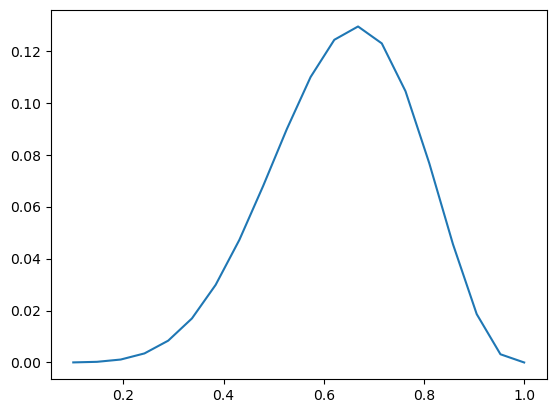

In [18]:
# I added a grain variable that tells it how many hypotheses to test

grain = 20 # 20 hypotheses

p_grid = np.linspace(.1,1,grain) 
prior_distribution = np.ones(grain) / sum(np.ones(grain))
likelihoods = stats.binom(n=9,p=p_grid).pmf(k=6)
posterior = likelihoods * prior_distribution
posterior = posterior / sum(posterior)
plt.plot(p_grid,posterior)

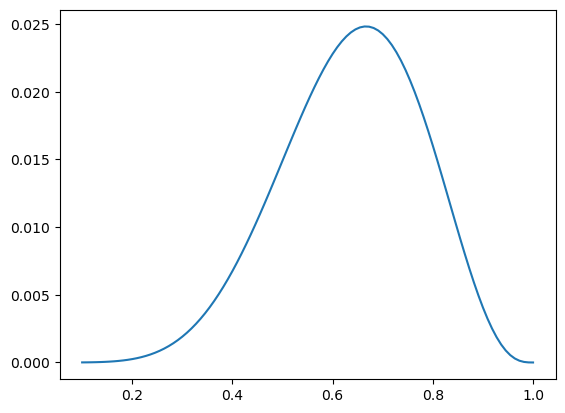

In [19]:
grain = 100 # 100 hypotheses

p_grid = np.linspace(.1,1,grain) 
prior_distribution = np.ones(grain) / sum(np.ones(grain))
likelihoods = stats.binom(n=9,p=p_grid).pmf(k=6)
posterior = likelihoods * prior_distribution
posterior = posterior / sum(posterior)
plt.plot(p_grid,posterior)

The lines look smoother as we increase the number of samples. That makes good sense. A more perplexing thing to notice is that, although the shape of the curve remains roughly the same, the height is actually decreasing. Notice the y-axis values. When we started, the peak was near 0.25. But as we add more hypotheses, the peak is near 0.025. It's 10 times smaller. However, we're also testing 10 as many hypotheses. Each hypotheses has to share some of the posterior distribution with all the others. So increasing the number of hypotheses generally decreases the average posterior value in the distribution. Graphing them all on the same axis demonstrates this nicely.

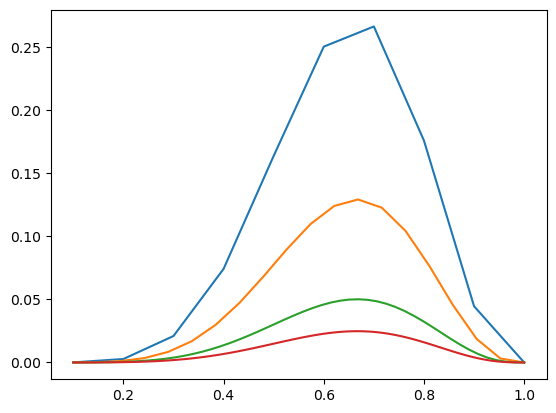

In [20]:
# 4 levels of gain stacked on top of each other

grain_list = [10,20,50,100]

for i in grain_list:
    grain = i

    p_grid = np.linspace(.1,1,grain) 
    prior_distribution = np.ones(grain) / sum(np.ones(grain))
    likelihoods = stats.binom(n=9,p=p_grid).pmf(k=6)
    posterior = likelihoods * prior_distribution
    posterior = posterior / sum(posterior)
    plt.plot(p_grid,posterior)

This problem - that the height of the posterior distribution shrinks as we add more hypotheses - has some fairly deep philosophical implications. Popper told us we can never discover the truth in science. We turned to Bayesian inference to try. Bayesian inference is a bigger help. It can tell us which hypotheses are better or worse. It's really good at comparative tasks. 

But you should not put to much emphasis on the absolute number attached to your posterior. If $P(H|E)$ is close to 1, that might mean that hypothesis is likely to be true. But it also might mean you aren't testing enough options. The posterior is only meaningful if you start with a good set options. In the end, it doesn't seem like Bayesian inference is a magical path to Enlightenment. But it does seem like an improvement over Popperian hypothesis testing.

## Improving the sample

We only have 9 observations. What happens to the shape of the posterior when we get more? Suppose we toss it 20 times and get 15 waters. Two things change. First, the posterior has moved over a bit $\frac{6}{9}$ is smaller than $\frac{15}{20}$.

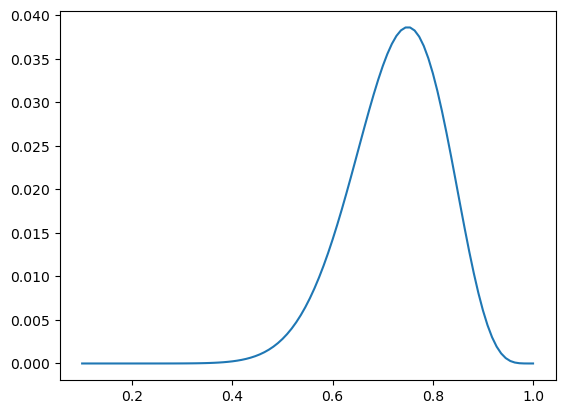

In [21]:
grain = 100

p_grid = np.linspace(.1,1,grain) 
prior_distribution = np.ones(grain) / sum(np.ones(grain))
likelihoods = stats.binom(n=20,p=p_grid).pmf(k=15)
posterior = likelihoods * prior_distribution
posterior = posterior / sum(posterior)
plt.plot(p_grid,posterior)

Second, the posterior is more clumped together around a smaller range of values. In other words, it's skinnier. We are more confident that the right water percentage lies in this range. 

Let's increase the number of samples again. Let's toss the globe 80 times for 55 waters. It gets skinnier again. That's makes sense. As the number of samples increases, we think our statistics should get better. Bayesian inference captures that idea nicely.

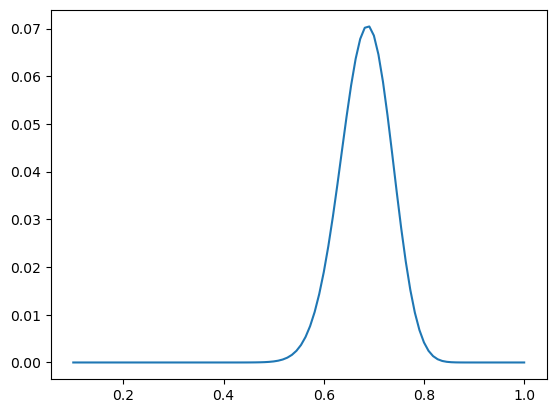

In [22]:
grain = 100

p_grid = np.linspace(.1,1,grain) 
prior_distribution = np.ones(grain) / sum(np.ones(grain))
likelihoods = stats.binom(n=80,p=p_grid).pmf(k=55)
posterior = likelihoods * prior_distribution
posterior = posterior / sum(posterior)
plt.plot(p_grid,posterior)

Let's stack all these graphs on top of each other. As the sample size increases, we actually face the opposite dynamic as we saw before. The absolute value along the y-axis increases as the sample increases.

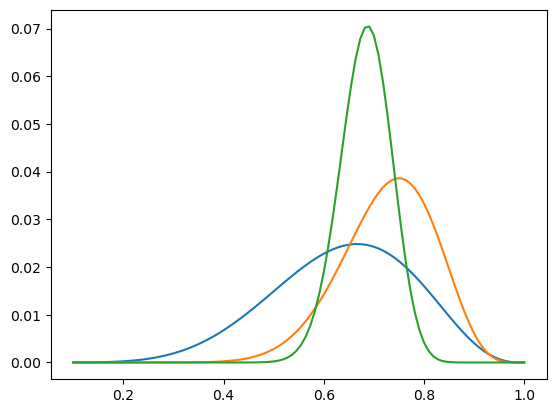

In [23]:
# 3 sample sizes stacked on top of each other.

water_counts = [6,15,55]
sample_sizes = [9,20,80]

for i in range(3):
    
    grain = 100

    p_grid = np.linspace(.1,1,grain) 
    prior_distribution = np.ones(grain) / sum(np.ones(grain))
    likelihoods = stats.binom(n=sample_sizes[i],p=p_grid).pmf(k=water_counts[i])
    posterior = likelihoods * prior_distribution
    posterior = posterior / sum(posterior)
    plt.plot(p_grid,posterior)
    
plt.show()

## Tinkering with prior distributions

So far, we've just been setting all the priors for they are equal to one another. This is a good assumption when you do not know anything at all about the system you are studying. But usually, you do know a few things. You have information *prior* to the data analysis. You can and should incorporate that into your prior distribution.

Think about the extreme cases - the earth is 1% water or 99% water. Are these very plausible hypotheses? Not really. I know life usually needs water to live. So, given that I exist at all, I should think there is probably a fair amount of water on the earth. I've also flown cross country from Vancouver to Toronto. That covers a lot of land. So I should think it's unlikely that there is 99% water. 

To build a prior distribution that incorporates these observations, we'll want something that assigns tiny probabilities to the extreme values and sizable probabilities to the middle values. More specifically, we could assume the priors are normally distributed.

In [21]:
# let's say we think the prior are normally distributed around 0.5 with standard deviation 0.

grain = 100
p_grid = np.linspace(0,1,grain)
prior_distribution = stats.norm(0.5,0.3).pdf(p_grid) # this takes each hypothesis and assigns it a prior
prior_distribution 

# one problem is that these numbers are too big. 
# some of these probabilities are greater than one. Which is impossible.

array([0.33159046, 0.35053149, 0.37013462, 0.3903912 , 0.41128984,
       0.4328163 , 0.45495336, 0.47768082, 0.50097538, 0.52481063,
       0.54915698, 0.5739817 , 0.59924888, 0.6249195 , 0.65095141,
       0.67729945, 0.7039155 , 0.73074858, 0.75774502, 0.78484853,
       0.81200044, 0.83913982, 0.86620373, 0.89312742, 0.91984457,
       0.94628755, 0.97238771, 0.99807561, 1.0232814 , 1.04793506,
       1.07196674, 1.09530711, 1.11788765, 1.13964098, 1.16050125,
       1.1804044 , 1.19928853, 1.2170942 , 1.23376475, 1.2492466 ,
       1.26348953, 1.27644695, 1.28807618, 1.29833863, 1.30720006,
       1.31463078, 1.32060575, 1.3251048 , 1.32811267, 1.32961917,
       1.32961917, 1.32811267, 1.3251048 , 1.32060575, 1.31463078,
       1.30720006, 1.29833863, 1.28807618, 1.27644695, 1.26348953,
       1.2492466 , 1.23376475, 1.2170942 , 1.19928853, 1.1804044 ,
       1.16050125, 1.13964098, 1.11788765, 1.09530711, 1.07196674,
       1.04793506, 1.0232814 , 0.99807561, 0.97238771, 0.94628

In [22]:
prior_distribution = prior_distribution / sum(prior_distribution) # but we can normalize it by dividing by the sum
prior_distribution # that looks better

array([0.00368983, 0.0039006 , 0.00411874, 0.00434415, 0.0045767 ,
       0.00481624, 0.00506258, 0.00531548, 0.00557469, 0.00583992,
       0.00611084, 0.00638708, 0.00666825, 0.0069539 , 0.00724358,
       0.00753677, 0.00783295, 0.00813154, 0.00843194, 0.00873354,
       0.00903568, 0.00933768, 0.00963884, 0.00993844, 0.01023574,
       0.01052998, 0.01082042, 0.01110627, 0.01138675, 0.01166109,
       0.0119285 , 0.01218823, 0.01243949, 0.01268156, 0.01291369,
       0.01313516, 0.0133453 , 0.01354343, 0.01372894, 0.01390122,
       0.01405971, 0.01420389, 0.0143333 , 0.0144475 , 0.0145461 ,
       0.01462879, 0.01469528, 0.01474534, 0.01477881, 0.01479558,
       0.01479558, 0.01477881, 0.01474534, 0.01469528, 0.01462879,
       0.0145461 , 0.0144475 , 0.0143333 , 0.01420389, 0.01405971,
       0.01390122, 0.01372894, 0.01354343, 0.0133453 , 0.01313516,
       0.01291369, 0.01268156, 0.01243949, 0.01218823, 0.0119285 ,
       0.01166109, 0.01138675, 0.01110627, 0.01082042, 0.01052

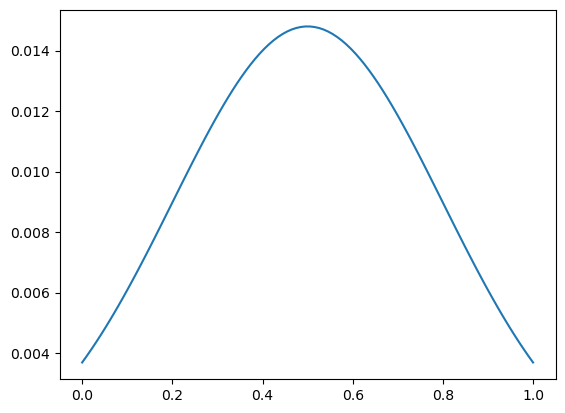

In [23]:
plt.plot(p_grid,prior_distribution)

Let's introduce one piece of data. Notice that it preserves a roughly normal shape but the posterior distribution shifts to the right. The prior has a fairly large influence on the overall shape. However, as more data comes in, the prior has less influence on the overall shape. Here are two plots that illustrate this point. The second has the full set of data influencing the posterior distributions.

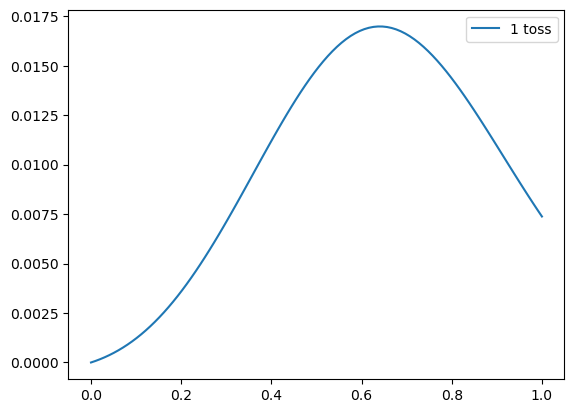

In [24]:
# now we run some data through bayes rule to transform the prior distribution

p_grid = np.linspace(0,1,grain)
prior_distribution = stats.norm(0.5,0.3).pdf(p_grid)
prior_distribution = prior_distribution / sum(prior_distribution) # normalize  it
likelihoods = stats.binom.pmf(1, 1, p=p_grid) # we adjust it here
posterior = likelihoods * prior_distribution
posterior = posterior / sum(posterior)
plt.plot(p_grid,posterior,label="1 toss")
plt.legend()
plt.show()

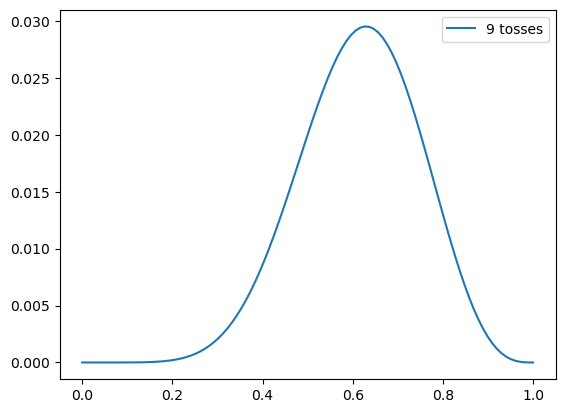

In [25]:
# adding the full set of data

p_grid = np.linspace(0,1,grain)
prior_distribution = stats.norm(0.5,0.3).pdf(p_grid)
prior_distribution = prior_distribution / sum(prior_distribution)
likelihoods = stats.binom.pmf(6, 9, p=p_grid) # we adjust it here
posterior = likelihoods * prior_distribution
posterior = posterior / sum(posterior)
plt.plot(p_grid,posterior,label="9 tosses")
plt.legend()
plt.show()

## Swamping the priors

This holds more generally. When the sample is small, the choice of the prior has a big influence. When the sample is big, the choice of prior makes little difference. The next series of plots helps illustrate this. At the beginning, the two distributions diverge. By the end, the distributions have fairly similar but not identical shapes. Bayesians call this phenomena "swamping the priors" because the influence of the evidence overwhelms the influence of the priors. Given enough evidence, almost all prior distributions always converge to exactly the same shape.

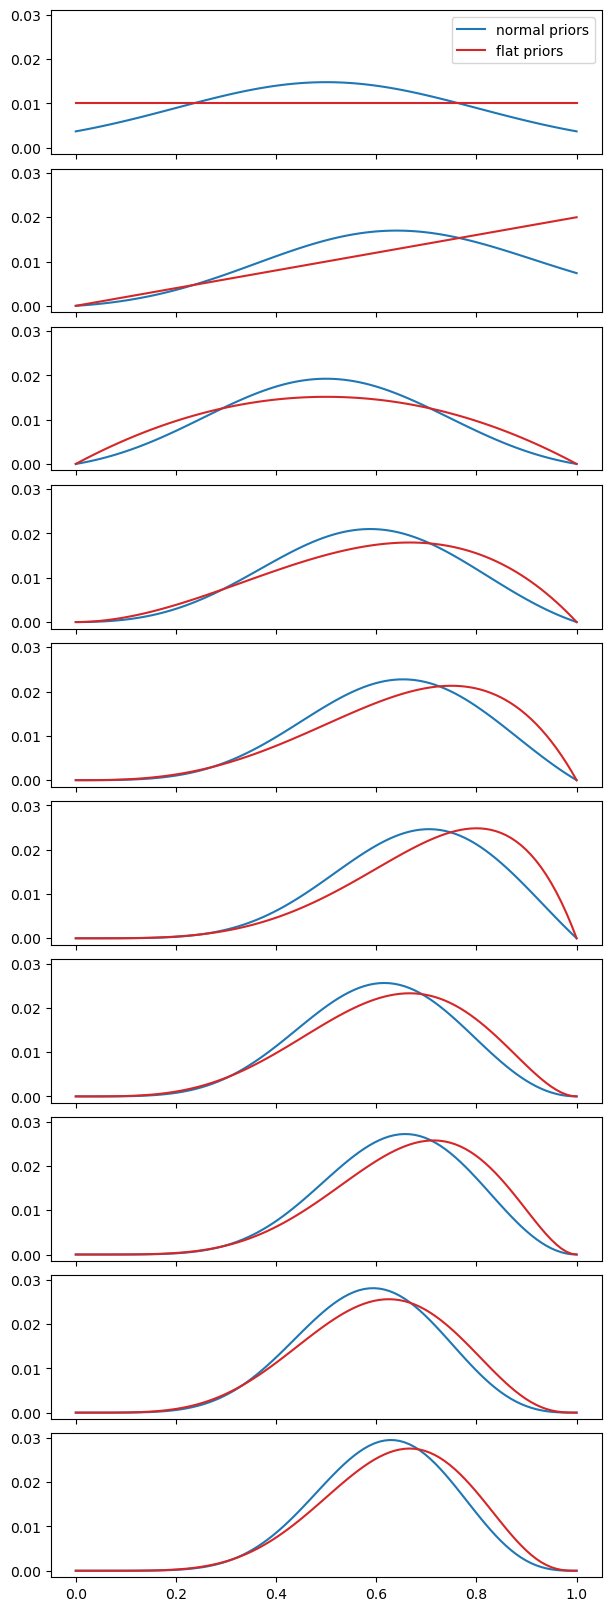

In [30]:
# All together now - comparing a normal and flat prior distribution

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

k = [1,1,2,3,4,4,5,5,6]
n = [1,2,3,4,5,6,7,8,9]

f, ax = plt.subplots(len(k)+1,sharex=True,sharey=True, figsize=(6, 16), constrained_layout=True)

grain = 100 # 100 hypotheses
p_grid = np.linspace(0,1,grain) 

prior_distribution_1 = stats.norm(0.5,0.3).pdf(p_grid)
prior_distribution_1 = prior_distribution_1 / sum(prior_distribution_1)
prior_distribution_2 = np.ones(grain) / sum(np.ones(grain))

ax[0].plot(p_grid,prior_distribution_1,label="normal priors",color="tab:blue")
ax[0].plot(p_grid,prior_distribution_2,label="flat priors",color="tab:red")
ax[0].legend()

for i in range(len(k)):
    likelihoods = stats.binom.pmf(k[i], n[i], p=p_grid)
    posterior_1 = likelihoods * prior_distribution_1
    posterior_1 = posterior_1 / sum(posterior_1)
    
    posterior_2 = likelihoods * prior_distribution_2
    posterior_2 = posterior_2 / sum(posterior_2)
    
    ax[i+1].plot(p_grid,posterior_1,color="tab:blue")
    ax[i+1].plot(p_grid,posterior_2,color="tab:red")

## Swamping the evidence

It's mostly true that all prior distributions *eventually* converge to the same answer. But some priors take longer to learn than others. You might call them 'stubborn priors.' Suppose you were unreasonably certain that the earth was exactly 25% water. Let's put 90% of the prior distribution there.

In [27]:
# it's a little tricky to get the prior distribution just right
# but if you split .1 / 19 you get the value of all the entries
# except for the entry correspondng to 25%
# and you can fix the value of the prior on 25% with the second line of code

prior_distribution = [0.005263157894736842] * 20
prior_distribution[4] = .9
sum(prior_distribution) # check to make sure it sums to 1 (give or take computer error)

1.0000000000000002

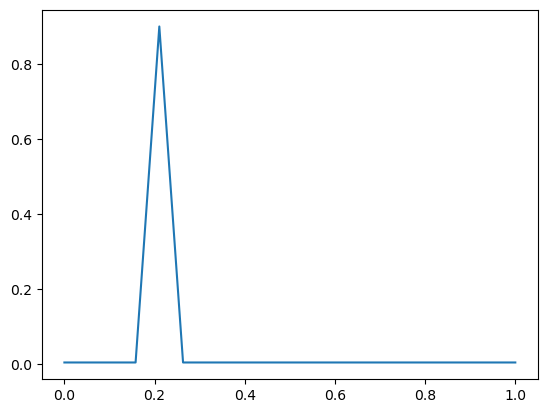

In [28]:
# visualize the prior

p_grid = np.linspace(0,1,20)
prior_distribution = [0.005263157894736842] * 20
prior_distribution[4] = .9
plt.plot(p_grid,prior_distribution)
plt.show()

After updating the distribution with the evidence, its shape looks really off. The evidence isn't strong enough to overwhelm this really extreme prior. This is just why Bayesian inference is controversial. It requires making extra assumptions - sometimes those assumptions can dampen the effect of the evidence. In principle, if you feed the prior an infinite amount of data, then even this extreme prior would behave properly. But, rarely, in science do we have an infinite amount of data.

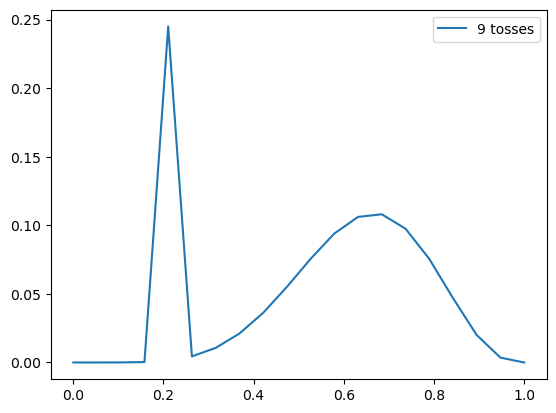

In [29]:
# the distribution after the update

p_grid = np.linspace(0,1,20)
likelihoods = stats.binom.pmf(6, 9, p=p_grid)
prior_distribution = [0.005263157894736842] * 20
prior_distribution[4] = .9
posterior = likelihoods * prior_distribution
posterior = posterior / sum(posterior)
plt.plot(p_grid,posterior,label="9 tosses")
plt.legend()
plt.show()